# Which modality predicts time to diagnosis best?

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import pylab as plt

from scipy import stats
from statannot import add_stat_annotation
import joblib
from functools import reduce

from importlib import reload
import sys
import os
sys.path.insert(1,'../')
import plots

In [2]:
reload(plots)
image_path = plots.set_dir()
colors = plots.set_colors()
data_path = '/scratch/c.c21013066/data/ukbiobank/analyses/survival/prodromal/noOsteo/'

In [3]:
fnames = ['intercept','genetics+family','lifestyle_nofam','blood','prodromalsigns_beforePD','all_acc_features',
         'all_acc_features+blood+lifestyle+genetics+prodromalsigns_beforePD']
names = ['no-skill','genetics+family','lifestyle','blood','prodromal signs','all accelerometer','combined']

aucss = []
meanss = []
mean = pd.DataFrame(index=fnames,columns=pd.MultiIndex.from_product([['population','unaffected','matched unaffected'],['mean','ste','std']],
                                                                    names=['control group','statistic']))
for diag,group in zip(['diag_ProdHC','diag_ProdallHC','diag_ProdPopulationNoPD'],['matched unaffected','unaffected','population']):
    aucs = []
    means = pd.DataFrame(index=fnames)
    for fi,fname in enumerate(fnames):
        # for population based model
        if diag == 'diag_ProdPopulationNoPD':
            cph_aucs = pd.read_csv(f'{data_path}/{fname}/{diag}_allHC/rsf_aucs_5cv.csv')
            means['control'] = group
        elif diag == 'diag_ProdHC':
            # for HC as controls
            cph_aucs = pd.read_csv(f'{data_path}{fname}/_matchedrsf_aucs_5cv.csv')
            means['control'] = group
        else:
            ph_aucs = pd.read_csv(f'{data_path}{fname}/_allHCrsf_aucs_5cv.csv')
            means['control'] = group
        auc = cph_aucs.iloc[:,2:].unstack().reset_index()
        auc['modality'] = fname
        auc['level_0'] = auc['level_0'].astype(float)
        aucs.append(auc)
        means.loc[fname,'mean'] = cph_aucs['mean'].mean()
        means.loc[fname,'std'] = cph_aucs['mean'].std()
        means.loc[fname,'ste'] = (cph_aucs['mean'].std())/np.sqrt(5)
        mean.loc[fname,(group,'mean')] = means.loc[fname,'mean']
        mean.loc[fname,(group,'ste')] = means.loc[fname,'ste']
        mean.loc[fname,(group,'std')] = means.loc[fname,'std']
    #means.to_csv(f'/scratch/c.c21013066/data/ukbiobank/analyses/survival/prodromal/noOsteo/means_{diag}.csv')
    aucs = pd.concat(aucs)
    aucss.append(aucs)
    meanss.append(means)
#mean.to_csv(f'/scratch/c.c21013066/data/ukbiobank/analyses/survival/prodromal/noOsteo/means.csv')

FileNotFoundError: [Errno 2] No such file or directory: '/scratch/c.c21013066/data/ukbiobank/analyses/survival/prodromal/noOsteo/all_acc_features+blood+lifestyle+genetics+prodromalsigns_beforePD/_allHCrsf_aucs_5cv.csv'

In [21]:
mean = pd.concat(meanss)

In [22]:
pd.pivot_table(mean.reset_index(),values=['mean','ste','std'],index='index',columns='control')

,mean,std,ste
control,matched unaffected,matched unaffected,matched unaffected
index,,,
all_acc_features,0.699570,4.666401e-02,2.086878e-02
all_acc_features+blood+lifestyle+genetics+prodromalsigns_beforePD,0.741284,4.231843e-02,1.892538e-02
blood,0.558751,6.072299e-02,2.715615e-02
genetics+family,0.502049,6.574407e-02,2.940164e-02
intercept,0.500000,5.551115e-17,2.482534e-17
lifestyle_nofam,0.459240,1.094211e-01,4.893460e-02
prodromalsigns_beforePD,0.456059,3.587068e-02,1.604186e-02


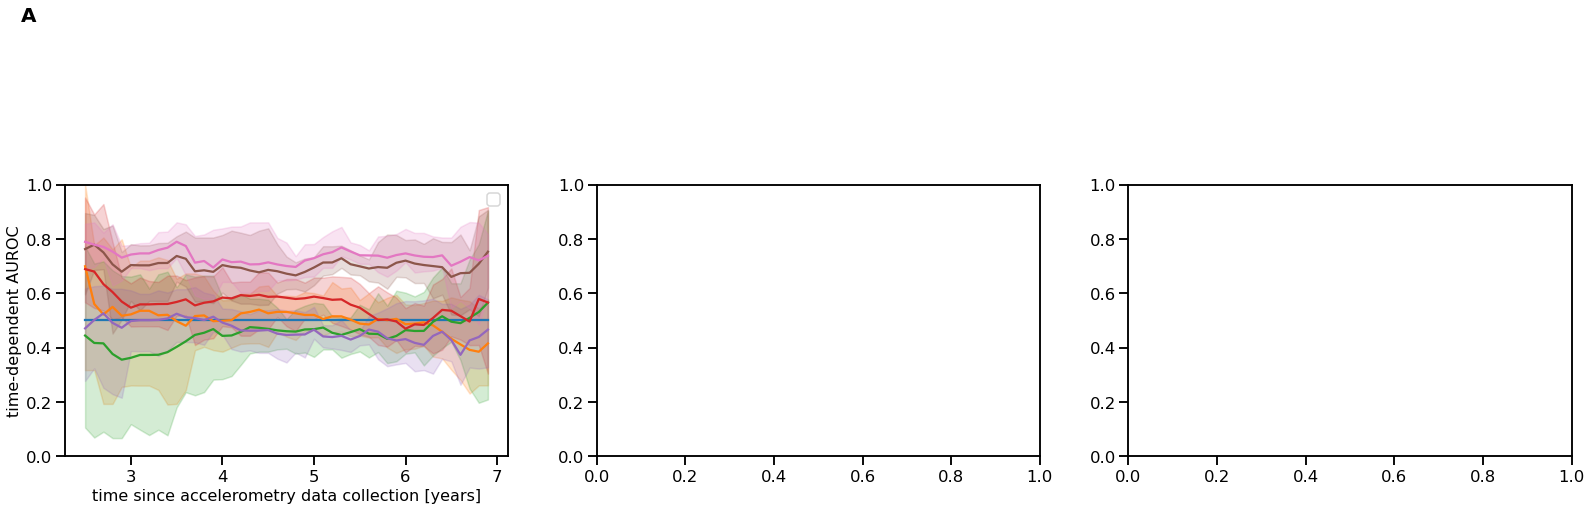

In [25]:
fig,axes = plt.subplots(ncols=3,figsize=(27,5))
plots.plot_context()
plotlabels = ['A','B','C']
for ax,aucs,means,plotlabel in zip(axes.flatten(),aucss,meanss,plotlabels):
    ax = sns.lineplot(x='level_0',y=0,data=aucs,ci=(100 - 0.05/len(names)),hue='modality',ax=ax)
    ax.set_xlabel('time since accelerometry data collection [years]')
    ax.set_ylabel('time-dependent AUROC')
    ax.set_ylim([0,1])
    ax.text(-0.1, 1.6,plotlabel, transform=ax.transAxes, 
            size=20, weight='bold')
    labels = []
    for fi,fname in enumerate(fnames):
        mean = means.loc[fname,'mean']
        ste = means.loc[fname,'ste']
        labels.append(f'{names[fi]}: {mean:.2f} ({ste:.2f})')
    #if plotlabel=='C':
    #    ax.set_ylim([0.5,1])
    if plotlabel == 'C':
        ax.legend(labels=labels,bbox_to_anchor=(0.8,1.6))
    else:
        ax.legend([],[])
#plt.savefig(f'{image_path}/rsf_5cv_AUCtime_modalities_HCpop.pdf',bbox_inches='tight',dpi=300)
#plt.savefig(f'{image_path}/rsf_5cv_AUCtime_modalities_HCpop.png',bbox_inches='tight',dpi=300)

In [26]:
means

,control,mean,std,ste
intercept,matched unaffected,0.500000,5.551115e-17,2.482534e-17
genetics+family,matched unaffected,0.502049,6.574407e-02,2.940164e-02
lifestyle_nofam,matched unaffected,0.459240,1.094211e-01,4.893460e-02
blood,matched unaffected,0.558751,6.072299e-02,2.715615e-02
prodromalsigns_beforePD,matched unaffected,0.456059,3.587068e-02,1.604186e-02
all_acc_features,matched unaffected,0.699570,4.666401e-02,2.086878e-02
all_acc_features+blood+lifestyle+genetics+prodromalsigns_beforePD,matched unaffected,0.741284,4.231843e-02,1.892538e-02


/tmp/ipykernel_86805/365194473.py:13: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  ax = sns.lineplot(x='level_0',y=0,data=aucs,ci=95,hue='modality')


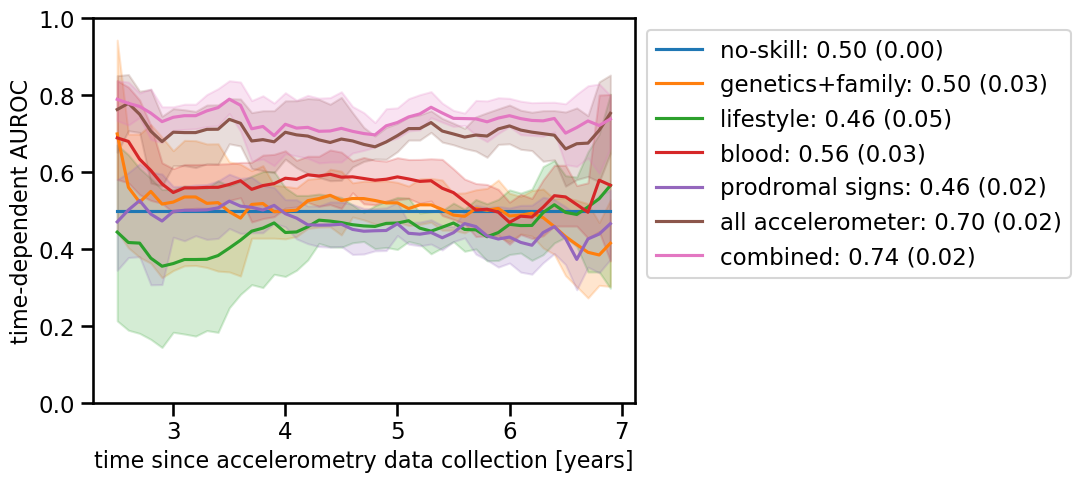

In [39]:
fig = plt.figure(figsize=(7,5))
plots.plot_context()
# aucs = aucss[0]
# means = meanss[0]
# labels = []
# print(means)
# for fi,fname in enumerate(fnames):
#     mean = means.loc[fname,'mean']
#     ste = means.loc[fname,'ste']
#     labels.append(f'{names[fi]}: {mean:.2f} ({ste:.2f})')
# dict_mod = dict(zip(fnames, labels))
# aucs['modality'] = aucs['modality'].replace(dict_mod)
ax = sns.lineplot(x='level_0',y=0,data=aucs,ci=95,hue='modality')
ax.set_xlabel('time since accelerometry data collection [years]')
ax.set_ylabel('time-dependent AUROC')
ax.set_ylim([0,1])
#lines, _= ax.get_legend_handles_labels()
ax.legend(bbox_to_anchor=(1,1))
#plt.savefig(f'{image_path}/rsf_5cv_AUCtime_modalities_HC.pdf',bbox_inches='tight',dpi=300)
plt.savefig(f'{image_path}/rsf_5cv_AUCtime_modalities_HC.png',bbox_inches='tight',dpi=300)

## look at specific model and the predictions

In [29]:
#pred = np.load(f'{data_path}/predictors.npy')
df_dummy_test = pd.read_csv(f'{data_path}/all_acc_features/_matchedrsftest_cv0.csv').set_index('eid')
coxnet_pred = joblib.load(f'{data_path}/all_acc_features/_matchedmodelrsf_CV0.joblib')

<frozen importlib._bootstrap>:219: RuntimeWarning: sklearn.tree._splitter.Splitter size changed, may indicate binary incompatibility. Expected 360 from C header, got 1160 from PyObject


In [30]:
prod = pd.read_csv('/scratch/c.c21013066/data/ukbiobank/merged_data/unaffectedNoOsteoAllHC.csv').set_index('eid')
prod = prod[prod['Status']!='Diseased']

In [31]:
for prod_eid in df_dummy_test[df_dummy_test['Status']==True].index:
    # find hc match
    hc_matches_eid = prod.loc[np.logical_and(prod['Status']=='Healthy',
                                      np.logical_and(prod['accelerometry_age'].round()==prod.loc[prod_eid,'accelerometry_age'].round(),
                                                     prod['male']==prod.loc[prod_eid,'male']))].index
    if len(hc_matches_eid)>0:
        for eid in hc_matches_eid:
            try:
                df_dummy_test.loc[eid]
                print('prod',prod_eid)
                print('hc',eid)
                break
            except:
                pass

prod 1085206
hc 2527367
prod 1090225
hc 2449497
prod 1254917
hc 4475960
prod 1316604
hc 1157026
prod 1556714
hc 1157026
prod 1566448
hc 1839583
prod 2103234
hc 1839583
prod 2247026
hc 5324142
prod 2964559
hc 1839583
prod 3082361
hc 3006477
prod 3234121
hc 2078208
prod 3391605
hc 5526259
prod 3532577
hc 1834951
prod 3737494
hc 5526259
prod 4868702
hc 2400041
prod 5032968
hc 1834951
prod 5906685
hc 5526259


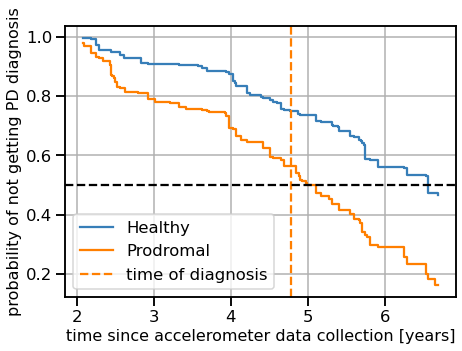

In [38]:
# test on new data
x_new = df_dummy_test.loc[([5526259,5906685])].iloc[:,2:]
pred_surv = coxnet_pred.predict_survival_function(x_new,return_array=True)
time_points = np.arange(2.5, 7,0.1)

fig = plt.figure(figsize=(7,5))
plots.plot_context()
for (i, surv_func),label,color in zip(enumerate(pred_surv),['Healthy','Prodromal'],[colors.healthy,colors.prodromal]):
    plt.step(coxnet_pred.event_times_, surv_func, where="post",
             label=label,color=color)
plt.ylabel("Survival probability")
plt.xlabel("Time in days")
plt.legend()
plt.grid(True)
plt.axvline(df_dummy_test.loc[([5906685]),'Survival_in_years'].values,0,1,ls='--',color=colors.prodromal,label='time of diagnosis')
plt.axhline(y=0.5,xmin=0,xmax=1,ls='--',color='black')
plt.ylabel("probability of not getting PD diagnosis")
plt.xlabel("time since accelerometer data collection [years]")
plt.legend(loc="best");
plt.savefig(f'{image_path}/rsfsurvival_prodhc_timeline.pdf',bbox_inches="tight",dpi=200)
plt.savefig(f'{image_path}/rsfsurvival_prodhc_timeline.png',bbox_inches="tight",dpi=300)

In [44]:
x_new = df_dummy_test.iloc[:,2:]
pred_surv = pd.DataFrame(coxnet_pred.predict_survival_function(x_new,return_array=True),index=x_new.index)
time_points = np.arange(2.5, 7,0.1)

In [54]:
prod = pd.read_csv('/scratch/c.c21013066/data/ukbiobank/merged_data/populationNoOsteoAllHC.csv').set_index('eid')
m = pd.merge(x_new,prod[['Status','diagnosis']],left_index=True,right_index=True,how='left')

In [55]:
merged = pd.merge(m,pred_surv,right_index=True,left_index=True,how='outer')
# get mean for each group
means = merged[~np.logical_and(merged['diagnosis']=='ParkinsonDisease',merged['Status']=='Prodromal')].groupby(['Status'])[pred_surv.columns].mean()
mean_prod = merged[np.logical_and(merged['diagnosis']=='ParkinsonDisease',merged['Status']=='Prodromal')][pred_surv.columns].mean()
means.loc['Prodromal PD',:] = mean_prod

stds = merged[~np.logical_and(merged['diagnosis']=='ParkinsonDisease',merged['Status']=='Prodromal')].groupby(['Status'])[pred_surv.columns].std()
std_prod = merged[np.logical_and(merged['diagnosis']=='ParkinsonDisease',merged['Status']=='Prodromal')][pred_surv.columns].std()
stds.loc['Prodromal PD',:] = std_prod

In [56]:
means

,0,1,2,3,4,5,6,7,8,9,...,80,81,82,83,84,85,86,87,88,89
Status,,,,,,,,,,,,,,,,,,,,,
Healthy,0.996942,0.993818,0.990684,0.984686,0.977725,0.975009,0.972047,0.968985,0.965813,0.962372,...,0.607825,0.604013,0.594326,0.588558,0.583862,0.572183,0.562403,0.544761,0.537988,0.508028
Prodromal PD,0.991657,0.984304,0.975167,0.967014,0.960625,0.953372,0.946692,0.937655,0.931078,0.925871,...,0.483329,0.472287,0.461593,0.446220,0.435377,0.425876,0.408872,0.389176,0.374302,0.361460


In [64]:
means.index = ['Other Diagnosis','Healthy','Other Prodromal','Prodromal PD']
stds.index = ['Other Diagnosis','Healthy','Other Prodromal','Prodromal PD']

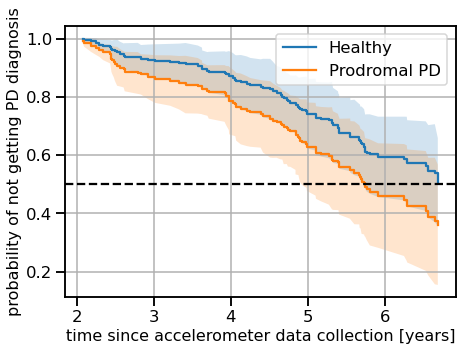

In [57]:
fig = plt.figure(figsize=(7,5))
plots.plot_context()
for key,surv_func in means.iterrows():
    plt.step(coxnet_pred.event_times_, surv_func, where="post",
             label=key)
    plt.fill_between(coxnet_pred.event_times_, surv_func+stds.loc[key],surv_func-stds.loc[key],alpha=0.2)
plt.ylabel("Survival probability")
plt.xlabel("Time in days")
plt.legend()
plt.grid(True)
#plt.axvline(df_dummy_test.loc[([5906685]),'Survival_in_years'].values,0,1,ls='--',color=colors.prodromal)
plt.axhline(y=0.5,xmin=0,xmax=1,ls='--',color='black')
plt.ylabel("probability of not getting PD diagnosis")
plt.xlabel("time since accelerometer data collection [years]")
plt.legend(bbox_to_anchor=(1,1));
plt.savefig(f'{image_path}/rsfKaplanMeyer_allaccelerometry_HC.pdf',bbox_inches="tight",dpi=300)
plt.savefig(f'{image_path}/rsfKaplanMeyer_allaccelerometry_HC.png',bbox_inches="tight",dpi=300)

## Sanity check: how many diagnoses per time interval in test data?

In [25]:
diag = 'diag_ProdPopulationNoPD'
preds_cv = []
real_cv = []
for fname in fnames:
    for cv in range(5):
        df_dummy_test = pd.read_csv(f'{data_path}/{fname}/{diag}/rsftest_cv{cv}.csv').set_index('eid')
        survfunc = np.load(f'{data_path}/{fname}/{diag}/rsf_testpred_CV{cv}.csv.npy')
        coxnet_pred = joblib.load(f'{data_path}/{fname}/{diag}/modelrsf_CV{cv}.joblib')
        time_points = coxnet_pred.event_times_
        preds = pd.DataFrame(index=df_dummy_test.index,columns=pd.MultiIndex.from_product([[fname],[cv]],
                                                                                         names = ['modality','cv']))
        real = pd.DataFrame(index=df_dummy_test.index,columns=pd.MultiIndex.from_product([[fname],[cv]],
                                                                                         names = ['modality','cv']))
        for si,subject in enumerate(df_dummy_test.index):
            try:
                index = list(map(lambda i: i < 0.5, survfunc[si])).index(True)
                preds.loc[subject,(fname,cv)] = time_points[index]
            except:
                preds.loc[subject,(fname,cv)] = np.nan
            real.loc[subject,(fname,cv)] = df_dummy_test.loc[subject,'Survival_in_years'] if \
                df_dummy_test.loc[subject,'Status'] else np.nan
        preds_cv.append(preds)
        real_cv.append(real)
preds_merged = reduce(lambda left, right: pd.merge(left, right, right_index=True,
                                                   left_index=True,how='outer'), preds_cv).astype(float)
real_merged = reduce(lambda left, right: pd.merge(left, right, right_index=True,
                                                  left_index=True,how='outer'), real_cv).astype(float)
preds_mean = preds_merged.mean(axis=1,level=0)
real_mean = real_merged.mean(axis=1,level=0)
# diagnoses per year
real_counts = real_mean.apply(lambda x: round(x, 0).value_counts()).sort_index()
pred_counts = preds_mean.apply(lambda x: round(x, 0).value_counts()).sort_index()
pred_counts = pred_counts.reindex(np.arange(2,8), fill_value=np.nan)

<frozen importlib._bootstrap>:219: RuntimeWarning: sklearn.tree._splitter.Splitter size changed, may indicate binary incompatibility. Expected 360 from C header, got 1160 from PyObject


In [26]:
real_counts = real_counts.iloc[:,0].rename('observed').to_frame()
counts = pd.merge(pred_counts,real_counts,right_index=True,left_index=True)

In [27]:
real_counts

,observed
2.0,12
3.0,13
4.0,18
5.0,36
6.0,18
7.0,2


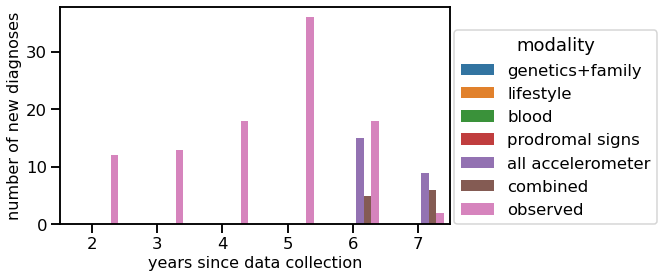

In [286]:
fig = plt.figure(figsize=(7,4))
plots.plot_context()
ax = sns.barplot(data=counts.unstack().reset_index(),x='level_1',y=0,hue='level_0')
ax.set_xlabel('years since data collection')
ax.set_ylabel('number of new diagnoses')
h, l = ax.get_legend_handles_labels()
plt.legend(h,np.hstack([names,'observed']),title='modality',loc=(1.01,0))
#plt.savefig(f'{image_path}/testset_true_diagnosistime.png',dpi=300)
#plt.savefig(f'{image_path}/testset_true_diagnosistime.pdf',dpi=300)

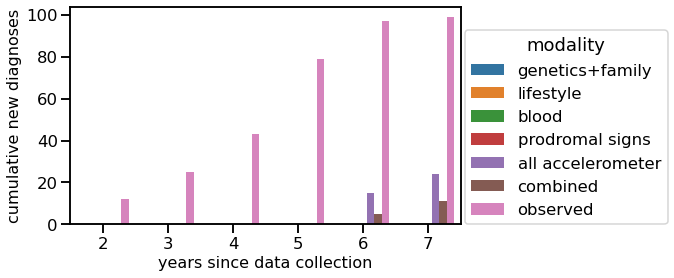

In [287]:
cumcounts = counts.cumsum()
fig = plt.figure(figsize=(7,4))
plots.plot_context()
ax = sns.barplot(data=cumcounts.unstack().reset_index(),x='level_1',y=0,hue='level_0')
ax.set_xlabel('years since data collection')
ax.set_ylabel('cumulative new diagnoses')
h, l = ax.get_legend_handles_labels()
plt.legend(h,np.hstack([names,'observed']),title='modality',loc=(1.01,0))
#plt.savefig(f'{image_path}/testset_true_diagnosistime.png',dpi=300)
#plt.savefig(f'{image_path}/testset_true_diagnosistime.pdf',dpi=300)

<BarContainer object of 6 artists>

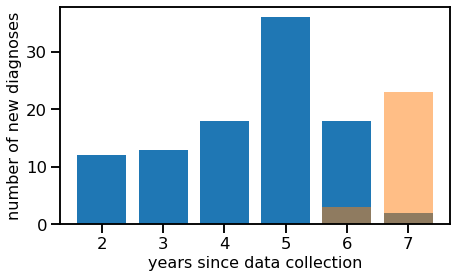

In [181]:
fig = plt.figure(figsize=(7,4))
plots.plot_context()
plt.bar(np.arange(2,8),real_counts)
plt.xlabel('years since data collection')
plt.ylabel('number of new diagnoses')
plt.savefig(f'{image_path}/testset_true_diagnosistime.png',dpi=300)
plt.savefig(f'{image_path}/testset_true_diagnosistime.pdf',dpi=300)